# Grid search for hyperparameter optimization for AdaBoostClassifier and RandomForestClassifier. Backtesting the strategies, calculating Sharpe ratio and dropdown

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle
from datetime import datetime
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

General idea: I will try to run everything (different label types, different optimal features) in one nested loop. I will save the performance of the strategy for each case in a list, and then analyze that list.

In [2]:
raw_data = pd.read_pickle(r'../lecture2/dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

I will consider 3 different label types:
1. (-1, 0, +1)
2. (-1, +1)
3. (-2, -1, 0, +1, +2)

In [3]:
def f1(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
        return 0

def f2(x):
    if x > 0:
        return 1
    else:
        return -1

def f3(x):
    absx = abs(x)
    signx = np.sign(x)
    if absx > 0.05:
        return signx*2
    elif absx > 0.01:
        return signx
    else:
        return 0

In [4]:
# adding all three kinds of labels to the data:
data['rel_performance1'] = data['pred_rel_return'].apply(f1)
data['rel_performance2'] = data['pred_rel_return'].apply(f2)
data['rel_performance3'] = data['pred_rel_return'].apply(f3)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
# as opposed to the lecture material, where we remove 'rel_performance', in this cell,
# I remove the columns ['rel_performance1', 'rel_performance2', 'rel_performance3']
# in the training and test data
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance1', 'rel_performance2', 'rel_performance3', 'pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance1', 'rel_performance2', 'rel_performance3','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [6]:
# The formulation of the problem does not specify what hyper parameters grid should be used.
# I will use the grid that we used in class:
param_grid = {'n_estimators': [15,25,35,40], 'max_features': ['sqrt','log2',0.5,0.3],
   'min_samples_leaf':[1000,1200,1800,2400], 'max_depth':[5,8,10,15]}

## Step 1

To find an optimal combination of hyper parameters for each choice of labels in this step, I will do a grid search using 2000--2003 as a training set and 2003-04-01--2003-07-01 as a validation set (using all features). This is what I do in the following cell:

In [13]:
np.random.seed(123)
optimal_hyper_params = []
for label_type_idx in range(1,4):
    # here I choose label type (1,2, or 3) accroding to label_type_idx values chosen above
    training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
    validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
    
    # gridsearch for best hyperparams:
    train = training_data[0]
    valid = test_data[0]
    combined = pd.concat([train, valid])
    y = np.append(training_labels[0], validation_labels[0])
    indices = np.append(-np.ones(len(train)),np.zeros(len(valid)))
    cv = PredefinedSplit(test_fold=indices)
    clf = GridSearchCV(RandomForestClassifier(bootstrap=True),
                   param_grid,cv=cv,n_jobs=-1,scoring='accuracy',verbose=3,
                   return_train_score=True)
    clf.fit(combined,y)
    print("-----------------------------------------------------------------")
    print("label_type_idx = ", label_type_idx)
    optimal_hyper_params.append(clf.best_params_)
    print("optimal hyperparameters = ", clf.best_params_)
    print("score = ", clf.best_score_)
    print("-----------------------------------------------------------------")

Fitting 1 folds for each of 256 candidates, totalling 256 fits
-----------------------------------------------------------------
label_type_idx =  1
optimal hyperparameters =  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1000, 'n_estimators': 15}
score =  0.5949214026602176
-----------------------------------------------------------------
Fitting 1 folds for each of 256 candidates, totalling 256 fits
-----------------------------------------------------------------
label_type_idx =  2
optimal hyperparameters =  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1000, 'n_estimators': 35}
score =  0.6299879081015719
-----------------------------------------------------------------
Fitting 1 folds for each of 256 candidates, totalling 256 fits
-----------------------------------------------------------------
label_type_idx =  3
optimal hyperparameters =  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1000, 'n_estimators': 15}
score =  0.447400241837

In [15]:
optimal_hyper_params

[{'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 1000,
  'n_estimators': 15},
 {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 1000,
  'n_estimators': 35},
 {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 1000,
  'n_estimators': 15}]

Backtesting all the combinations of optimal features and label types (there is 6 opt_feat files, not 7):

In [20]:
all_results = []
for opt_feat_idx in range(1,7):
    with open(f'opt_feature_files/opt_feat_{opt_feat_idx}.pkl','rb') as f:
        optimal_features = pickle.load(f)
    for label_type_idx in range(1,4):
        # here I choose label type (1,2, or 3) accroding to label_type_idx values chosen above
        print("Working on opt_feat_idx = ", opt_feat_idx, ", label_type_idx = ", label_type_idx)
        training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
        validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
        hyper_params = optimal_hyper_params[label_type_idx-1]
        results = {"label_type_idx": label_type_idx, "opt_feat_idx": opt_feat_idx,
                   "opt_feat_file": f"opt_feat_{opt_feat_idx}.pkl",
                   "hyper_params": hyper_params}
        rf_clf = RandomForestClassifier(bootstrap=True, n_jobs=-1, **hyper_params)
        P_L = []
        x = [0,1]
        ret = []
        for i in range(1,len(optimal_features)-1):
                rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
                pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
                profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
                positions = np.sum(np.abs(pred_i))
                x.append(x[i] + (x[i]/positions) * profit_i)
        results['x'] = x
        all_results.append(results)

Working on opt_feat_idx =  1 , label_type_idx =  1
Working on opt_feat_idx =  1 , label_type_idx =  2
Working on opt_feat_idx =  1 , label_type_idx =  3
Working on opt_feat_idx =  2 , label_type_idx =  1
Working on opt_feat_idx =  2 , label_type_idx =  2
Working on opt_feat_idx =  2 , label_type_idx =  3
Working on opt_feat_idx =  3 , label_type_idx =  1
Working on opt_feat_idx =  3 , label_type_idx =  2
Working on opt_feat_idx =  3 , label_type_idx =  3
Working on opt_feat_idx =  4 , label_type_idx =  1
Working on opt_feat_idx =  4 , label_type_idx =  2
Working on opt_feat_idx =  4 , label_type_idx =  3
Working on opt_feat_idx =  5 , label_type_idx =  1
Working on opt_feat_idx =  5 , label_type_idx =  2
Working on opt_feat_idx =  5 , label_type_idx =  3
Working on opt_feat_idx =  6 , label_type_idx =  1
Working on opt_feat_idx =  6 , label_type_idx =  2
Working on opt_feat_idx =  6 , label_type_idx =  3


In [21]:
len(all_results)

18

Calculating the performance of all the considered strategies and saving the results in the list:

In [22]:
SPY0 = pd.read_pickle(r'../lecture2/SPY_cum_ret.pkl')
for results in all_results:
    x = results['x']
    SPY = SPY0.copy()
    SPY = SPY.loc['2003-10-01':]
    SPY = SPY.resample('Q').ffill()
    SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
    SPY['strategy'] = x[1:]
    results['quarterly_data'] = SPY.copy()
    SPY = SPY.resample('A').bfill()
    results['annual_data'] = SPY.copy()
    strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
    strategy_std = (SPY['strategy'] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    results['Strategy Sharpe Ratio'] = strategy_sr
    results['SP Sharpe Ratio'] = (SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std()
    results['Strategy total return'] = x[-1]
    results['SPY total return'] = SPY['spy_cum_ret'][-1]
    avr = np.exp(np.log(x[-1])/15.) - 1
    results['Average annual return'] = avr
    sp_avr = np.exp(np.log(SPY['spy_cum_ret'][-1])/15) - 1
    results['SPY average annual return'] = sp_avr
    strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
    spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    results['beta'] = beta
    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    results['Information Ratio'] = IR
    alpha = np.mean(residual_ret)
    results['Strategy alpha'] = alpha

In [24]:
all_results[0]

{'label_type_idx': 1,
 'opt_feat_idx': 1,
 'opt_feat_file': 'opt_feat_1.pkl',
 'hyper_params': {'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 1000,
  'n_estimators': 15},
 'x': [0,
  1,
  1.1047145721649485,
  1.2257503912392116,
  1.217668350318649,
  1.1901856220393228,
  1.2902336796503364,
  1.392024981460798,
  1.3717645398374083,
  1.5229205526182588,
  1.4999303522256966,
  1.6647929627776432,
  1.7541093483030963,
  1.6667373900831708,
  1.8249619115035531,
  1.9430537505752856,
  2.0480105368519856,
  2.0126026927674685,
  2.0320384194513177,
  1.8969966271973089,
  1.9654159046255542,
  1.888988144687692,
  1.360284330471187,
  1.3552587631513788,
  1.513165651758075,
  1.6938837173645227,
  1.758523503870029,
  1.8685885680596113,
  2.031735262600006,
  1.9862000104846664,
  2.1987671839033682,
  2.459398482042046,
  2.5618741625784,
  2.3279754956373697,
  2.329881439955212,
  2.5876911843343726,
  2.5885233448093485,
  2.5680897908859697,
  2.674423953285

### Creating a function to find max yearly drawdown

<AxesSubplot:xlabel='date'>

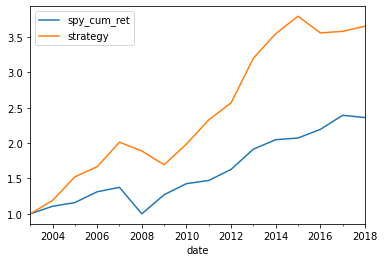

In [25]:
# let's use first combination of parameters as an example
all_results[0]['annual_data'].plot()

I will make my own function for max drawdown calculation:

I use the fact that in the region between a local max and the **next** local min, the slope of the curve is negative, by definition. Thus, I find the regions (start_index, end_index) where the slope is negative. Then, a drawdown is just the drop in each such region. Then, I divide the absolute drop by the value of the curve at the beginning of the drop. I think a relative drop is more relevant to characterize how anxious investors are.

In [26]:
# this cell finds index ranges of return drops
ys = all_results[0]['annual_data']['strategy']
diff = ys.diff().fillna(0)
drawdown_indexes = [] # list of tuples (start_of_drop, end_of_drop)
i = 0
while i < len(ys):
    if diff[i] < 0: # find the beginning of drop
        start_idx = i-1
        while i < len(ys) and diff[i] < 0: # go on until the end of the drop
            i += 1
        end_idx = i-1
        drawdown_indexes.append((start_idx, end_idx))
    else:
        i += 1
drawdown_indexes

[(4, 6), (12, 13)]

In [27]:
drawdowns = [(ys[start_idx]-ys[end_idx])/ys[start_idx] for start_idx, end_idx in drawdown_indexes]
drawdowns

[0.15836159642849582, 0.06211032878912456]

In [28]:
# The above calculation of drawdown seems to work. Let us define it as a funciton:
def get_max_drawdown(ys):
    diff = ys.diff().fillna(0)
    drawdown_indexes = [] # list of tuples (start_of_drop, end_of_drop)
    i = 0
    while i < len(ys):
        if diff[i] < 0: # find the beginning of drop
            start_idx = i-1
            while i < len(ys) and diff[i] < 0: # go on until the end of the drop
                i += 1
            end_idx = i-1
            drawdown_indexes.append((start_idx, end_idx))
        else:
            i += 1
    drawdowns = [(ys[start_idx]-ys[end_idx])/ys[start_idx] for start_idx, end_idx in drawdown_indexes]
    max_drawdown = max(drawdowns) if len(drawdowns) else 0 # no drawdowns is a possibility
    return max_drawdown

In [29]:
# calculate max drawdown for all strategies:
for res in all_results:
    res['max_drawdown'] = get_max_drawdown(res['annual_data']['strategy'])

In [34]:
# auxiliary function to print performance of a given strategy
def print_strategy_performance(res):
    print("----------------------------------------------------------------------------")
    res['annual_data'].plot()
    plt.show()
    for key, val in res.items():
            if key in ["x", "annual_data", "quarterly_data"]:
                continue
            else:
                print(key, " = ", val)
    print("----------------------------------------------------------------------------")

Strategy with the smallest max_drawdown:
----------------------------------------------------------------------------


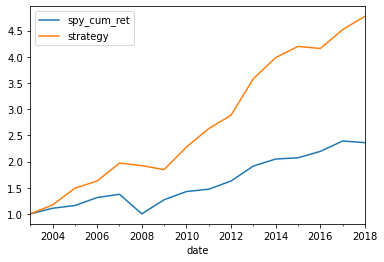

label_type_idx  =  1
opt_feat_idx  =  6
opt_feat_file  =  opt_feat_6.pkl
hyper_params  =  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1000, 'n_estimators': 15}
Strategy Sharpe Ratio  =  1.2237697383365584
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  4.773721331685418
SPY total return  =  2.360200999999999
Average annual return  =  0.10983173115138034
SPY average annual return  =  0.058920280465017294
beta  =  0.5528650803085445
Information Ratio  =  1.100678713383442
Strategy alpha  =  0.2014475797723104
max_drawdown  =  0.06320824255475331
----------------------------------------------------------------------------


In [35]:
# find the smallest max drawdown among all strategies:
all_drawdowns = np.array([res['max_drawdown'] for res in all_results])
min_idx = np.argmin(all_drawdowns)
opt_res = all_results[min_idx]
print("Strategy with the smallest max_drawdown:")
print_strategy_performance(opt_res)

Luckily the above strategy also has a good Sharpe Ratio (>1). Thus, this strategy is the answer to Step 1 --- small drawdown and good Sharpe ratio

## Step 2

Almost everything will be the same as in Step 1. Just a differrent model, a different  ```param_grid```, and different optimal features files.

In [37]:
# I will consider the following grid of values of n_estimators and learning_rate:
param_grid = {'n_estimators': [15,25,35,40], 'learning_rate': [0.01, 0.1, 0.5, 0.75]}

In [38]:
np.random.seed(123)
optimal_hyper_params = []
for label_type_idx in range(1,4):
    # here I choose label type (1,2, or 3) accroding to label_type_idx values chosen above
    training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
    validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
    
    # gridsearch for best hyperparams:
    train = training_data[0]
    valid = test_data[0]
    combined = pd.concat([train, valid])
    y = np.append(training_labels[0], validation_labels[0])
    indices = np.append(-np.ones(len(train)),np.zeros(len(valid)))
    cv = PredefinedSplit(test_fold=indices)
    clf = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), algorithm="SAMME.R"),
                   param_grid,cv=cv,n_jobs=-1,scoring='accuracy',verbose=3,
                   return_train_score=True)
    clf.fit(combined,y)
    print("-----------------------------------------------------------------")
    print("label_type_idx = ", label_type_idx)
    optimal_hyper_params.append(clf.best_params_)
    print("optimal hyperparameters = ", clf.best_params_)
    print("score = ", clf.best_score_)
    print("-----------------------------------------------------------------")

Fitting 1 folds for each of 16 candidates, totalling 16 fits
-----------------------------------------------------------------
label_type_idx =  1
optimal hyperparameters =  {'learning_rate': 0.1, 'n_estimators': 25}
score =  0.562273276904474
-----------------------------------------------------------------
Fitting 1 folds for each of 16 candidates, totalling 16 fits
-----------------------------------------------------------------
label_type_idx =  2
optimal hyperparameters =  {'learning_rate': 0.1, 'n_estimators': 35}
score =  0.592503022974607
-----------------------------------------------------------------
Fitting 1 folds for each of 16 candidates, totalling 16 fits
-----------------------------------------------------------------
label_type_idx =  3
optimal hyperparameters =  {'learning_rate': 0.1, 'n_estimators': 25}
score =  0.42563482466747277
-----------------------------------------------------------------


Backtesting all the combinations of optimal features and label types (oddly there is no ```ada_opt_feat_2.pkl```):

In [41]:
all_results = []
for opt_feat_idx in [1,3,4,5,6]:
    with open(f'opt_feature_files/ada_opt_feat_{opt_feat_idx}.pkl','rb') as f:
        optimal_features = pickle.load(f)
    for label_type_idx in range(1,4):
        # here I choose label type (1,2, or 3) accroding to label_type_idx values chosen above
        print("Working on opt_feat_idx = ", opt_feat_idx, ", label_type_idx = ", label_type_idx)
        training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
        validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
        hyper_params = optimal_hyper_params[label_type_idx-1]
        results = {"label_type_idx": label_type_idx, "opt_feat_idx": opt_feat_idx,
                   "opt_feat_file": f"ada_opt_feat_{opt_feat_idx}.pkl",
                   "hyper_params": hyper_params}
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), algorithm="SAMME.R", **hyper_params)
        P_L = []
        x = [0,1]
        ret = []
        for i in range(1,len(optimal_features)-1):
                ada_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
                pred_i = ada_clf.predict(test_data[i][optimal_features[i-1]])
                profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
                positions = np.sum(np.abs(pred_i))
                x.append(x[i] + (x[i]/positions) * profit_i)
        results['x'] = x
        all_results.append(results)

Working on opt_feat_idx =  1 , label_type_idx =  1
Working on opt_feat_idx =  1 , label_type_idx =  2
Working on opt_feat_idx =  1 , label_type_idx =  3
Working on opt_feat_idx =  3 , label_type_idx =  1
Working on opt_feat_idx =  3 , label_type_idx =  2
Working on opt_feat_idx =  3 , label_type_idx =  3
Working on opt_feat_idx =  4 , label_type_idx =  1
Working on opt_feat_idx =  4 , label_type_idx =  2
Working on opt_feat_idx =  4 , label_type_idx =  3
Working on opt_feat_idx =  5 , label_type_idx =  1
Working on opt_feat_idx =  5 , label_type_idx =  2
Working on opt_feat_idx =  5 , label_type_idx =  3
Working on opt_feat_idx =  6 , label_type_idx =  1
Working on opt_feat_idx =  6 , label_type_idx =  2
Working on opt_feat_idx =  6 , label_type_idx =  3


In [42]:
len(all_results)

15

Calculating the performance of all the considered strategies and saving the results in the list:

In [43]:
SPY0 = pd.read_pickle(r'../lecture2/SPY_cum_ret.pkl')
for results in all_results:
    x = results['x']
    SPY = SPY0.copy()
    SPY = SPY.loc['2003-10-01':]
    SPY = SPY.resample('Q').ffill()
    SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
    SPY['strategy'] = x[1:]
    results['quarterly_data'] = SPY.copy()
    SPY = SPY.resample('A').bfill()
    results['annual_data'] = SPY.copy()
    strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
    strategy_std = (SPY['strategy'] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    results['Strategy Sharpe Ratio'] = strategy_sr
    results['SP Sharpe Ratio'] = (SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std()
    results['Strategy total return'] = x[-1]
    results['SPY total return'] = SPY['spy_cum_ret'][-1]
    avr = np.exp(np.log(x[-1])/15.) - 1
    results['Average annual return'] = avr
    sp_avr = np.exp(np.log(SPY['spy_cum_ret'][-1])/15) - 1
    results['SPY average annual return'] = sp_avr
    strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
    spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    results['beta'] = beta
    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    results['Information Ratio'] = IR
    alpha = np.mean(residual_ret)
    results['Strategy alpha'] = alpha

In [44]:
all_results[0]

{'label_type_idx': 1,
 'opt_feat_idx': 1,
 'opt_feat_file': 'ada_opt_feat_1.pkl',
 'hyper_params': {'learning_rate': 0.1, 'n_estimators': 25},
 'x': [0,
  1,
  1.096894410548087,
  1.2142098577941265,
  1.207222564230056,
  1.1966864711907188,
  1.2915446377723308,
  1.393667804118286,
  1.374343095737826,
  1.508592526456613,
  1.4865698927343454,
  1.637747109634026,
  1.7200876567038728,
  1.653753784853117,
  1.801064682718662,
  1.9169977875006141,
  2.0215377325865225,
  1.9954706841091894,
  2.029640954751429,
  1.879242420175111,
  1.9528017147949877,
  1.8713387391060714,
  1.3268752376152277,
  1.310591062386336,
  1.4513100653076705,
  1.673482132989186,
  1.8005073602698776,
  1.8896785633551714,
  2.079560757568265,
  2.011978909873719,
  2.217318730904538,
  2.4653827708401255,
  2.5657024305076854,
  2.347076603785767,
  2.3660133275511432,
  2.5872240146296326,
  2.591400586993454,
  2.5639024892091005,
  2.64064091731583,
  2.89323664858851,
  3.029134465669702,
  3.06

In [45]:
# calculate max drawdown for all strategies:
for res in all_results:
    res['max_drawdown'] = get_max_drawdown(res['annual_data']['strategy'])

In [46]:
# auxiliary function to print performance of a given strategy
def print_strategy_performance(res):
    print("----------------------------------------------------------------------------")
    res['annual_data'].plot()
    plt.show()
    for key, val in res.items():
            if key in ["x", "annual_data", "quarterly_data"]:
                continue
            else:
                print(key, " = ", val)
    print("----------------------------------------------------------------------------")

Strategy with the smallest max_drawdown:
----------------------------------------------------------------------------


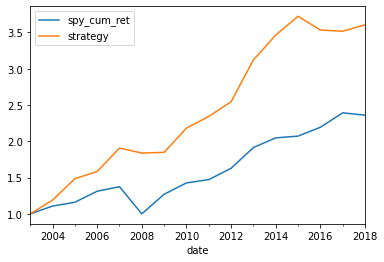

label_type_idx  =  2
opt_feat_idx  =  4
opt_feat_file  =  ada_opt_feat_4.pkl
hyper_params  =  {'learning_rate': 0.1, 'n_estimators': 35}
Strategy Sharpe Ratio  =  0.8938720311763565
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  3.604564356442271
SPY total return  =  2.360200999999999
Average annual return  =  0.08923984307745614
SPY average annual return  =  0.058920280465017294
beta  =  0.45109052165941643
Information Ratio  =  0.7507444598362346
Strategy alpha  =  0.13273270518604077
max_drawdown  =  0.05554181024161462
----------------------------------------------------------------------------


In [47]:
# find the smallest max drawdown among all strategies:
all_drawdowns = np.array([res['max_drawdown'] for res in all_results])
min_idx = np.argmin(all_drawdowns)
opt_res = all_results[min_idx]
print("Strategy with the smallest max_drawdown:")
print_strategy_performance(opt_res)

In this case the strategy with the smallest drawdown has a Sharpe Ratio = 0.89 < 1. Let's see if we can find another strategy with Sharpe Ratio > 1, and a low max drawadown:

In [50]:
good_sharpe_ratio_results = [res for res in all_results if res['Strategy Sharpe Ratio'] > 1]
len(good_sharpe_ratio_results)

0

Well, unfortunately, there are no strategies with Sharpe Ratio > 1. Let's see if at least we have a better than 0.89 Sharpe Ratio

Strategy with the smallest max_drawdown:
----------------------------------------------------------------------------


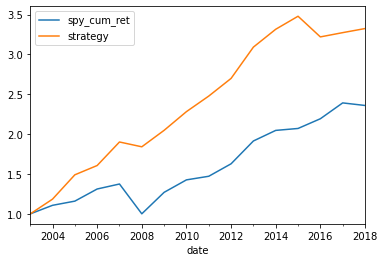

label_type_idx  =  2
opt_feat_idx  =  3
opt_feat_file  =  ada_opt_feat_3.pkl
hyper_params  =  {'learning_rate': 0.1, 'n_estimators': 35}
Strategy Sharpe Ratio  =  0.9668259457011948
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  3.32484343286291
SPY total return  =  2.360200999999999
Average annual return  =  0.08338981041909577
SPY average annual return  =  0.058920280465017294
beta  =  0.45540048695702073
Information Ratio  =  0.8049580278862505
Strategy alpha  =  0.11369381567356561
max_drawdown  =  0.07446689941540524
----------------------------------------------------------------------------


In [53]:
sharpe_ratios = [res['Strategy Sharpe Ratio'] for res in all_results]
max_sharpe_idx = np.argmax(sharpe_ratios)
opt_res = all_results[max_sharpe_idx]
print("Strategy with the smallest max_drawdown:")
print_strategy_performance(opt_res)

OK. This strategy has almost the same ```max_drawdown```, but a noticeably better Sharpe Ratio (0.97). So, for Problem 2, this strategy is the answer, in my opinion.

This strategy has a lower total return than the random forest strategy in Problem 1. However, one aspect in which this strategy is better is the fact that it recovered from the financial crisis faster than the random forest model: 1 year vs 2 years.